In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# Dataset

In [2]:
n_samples = 10
cluster_radius = 3.5
dataset = np.zeros((n_samples * 2, 3), dtype=np.float32)

## Cluster 0

In [3]:
centroid_0 = np.array([1, 1], dtype=np.float32)

sample_radio = (cluster_radius * np.random.uniform(0, 1, n_samples))
sample_angl = (2 * np.pi * np.random.uniform(0, 1, n_samples))

dataset[:n_samples, 0] = centroid_0[0] + sample_radio[:]*(np.cos(sample_angl[:]))
dataset[:n_samples, 1] = centroid_0[1] + sample_radio[:]*(np.sin(sample_angl[:]))

## Cluster 1

In [4]:
centroid_1 = np.array([8, 8], dtype=np.float32)

sample_radio = (cluster_radius * np.random.uniform(0, 1, n_samples))
sample_angl = (2 * np.pi * np.random.uniform(0, 1, n_samples))

dataset[n_samples:, 0] = centroid_1[0] + sample_radio[:]*(np.cos(sample_angl[:]))
dataset[n_samples:, 1] = centroid_1[1] + sample_radio[:]*(np.sin(sample_angl[:]))
dataset[n_samples:, 2] = 1

In [5]:
print(dataset.shape)
print(dataset[12:15])

(20, 3)
[[9.704624  6.787508  1.       ]
 [5.5202665 8.742043  1.       ]
 [9.80869   9.354586  1.       ]]


## Visualization

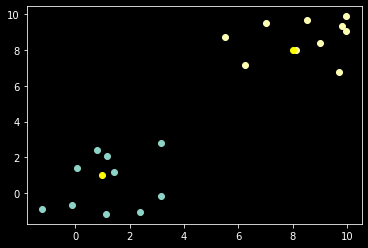

In [6]:
plt.scatter(dataset[:n_samples, 0], dataset[:n_samples, 1])
plt.scatter(dataset[n_samples:, 0], dataset[n_samples:, 1])
plt.scatter(centroid_0[0], centroid_0[1], color="yellow")
plt.scatter(centroid_1[0], centroid_1[1], color="yellow")
plt.show()

# Preparar dataset en PyTorch

In [7]:
from torch.utils.data import Dataset
from torch import tensor

class ClassificationDataset(Dataset):
    def __init__(self, n_samples_per_class, centroid_0, radius_0, centroid_1, radius_1):
        self.dataset = np.zeros((n_samples_per_class * 2, 3), dtype=np.float32)
        self.createDataset(n_samples_per_class, centroid_0, radius_0, centroid_1, radius_1)
        
        self.n_samples = n_samples_per_class
        self.centroid_0 = centroid_0
        self.centroid_1 = centroid_1
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, idx):
        x = tensor(self.dataset[idx, [0,1]])
        y = tensor(self.dataset[idx, 1])
            
        return [x, y]
    
    def createDataset(self, n_samples_per_class, centroid_0, radius_0, centroid_1, radius_1):
        sample_radio_0 = (radius_0 * np.random.uniform(0, 1, n_samples_per_class))
        sample_angl_0 = (2 * np.pi * np.random.uniform(0, 1, n_samples_per_class))
        self.dataset[:n_samples_per_class, 0] = centroid_0[0] + sample_radio_0[:]*(np.cos(sample_angl_0[:]))
        self.dataset[:n_samples_per_class, 1] = centroid_0[1] + sample_radio_0[:]*(np.sin(sample_angl_0[:]))
        
        sample_radio_1 = (cluster_radius * np.random.uniform(0, 1, n_samples_per_class))
        sample_angl_1 = (2 * np.pi * np.random.uniform(0, 1, n_samples_per_class))

        self.dataset[n_samples_per_class:, 0] = centroid_1[0] + sample_radio_1[:]*(np.cos(sample_angl_1[:]))
        self.dataset[n_samples_per_class:, 1] = centroid_1[1] + sample_radio_1[:]*(np.sin(sample_angl_1[:]))
        self.dataset[n_samples_per_class:, 2] = 1
        
    def show(self):
        plt.scatter(self.dataset[:self.n_samples, 0], self.dataset[:self.n_samples, 1])
        plt.scatter(self.dataset[self.n_samples:, 0], self.dataset[self.n_samples:, 1])
        plt.scatter(self.centroid_0[0], self.centroid_0[1], color="yellow")
        plt.scatter(self.centroid_1[0], self.centroid_1[1], color="yellow")
        plt.show()

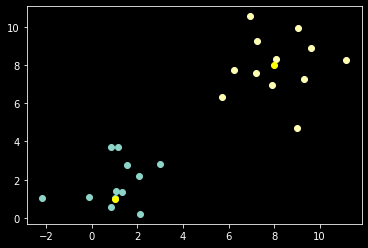

torch.Size([21, 2])
torch.Size([21])
torch.Size([3, 2])
torch.Size([3])


In [8]:
from torch.utils.data import DataLoader

# n_samples_per_class, centroid_0, radius_0, centroid_1, radius_1

n_samples = 12
cluster_radius = 3.5
centroid_0 = np.array([1, 1], dtype=np.float32)
centroid_1 = np.array([8, 8], dtype=np.float32)


train_set = ClassificationDataset(n_samples, centroid_0, cluster_radius, centroid_1, cluster_radius)
validation_set = ClassificationDataset(12, centroid_0, cluster_radius, centroid_1, cluster_radius)

train_set.show()

batch_size = 21

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=0),
}

for inputs, labels in dataloaders['train']:
     print(inputs.size())
     print(labels.size())
    

# Perceptron

In [9]:
class Perceptron(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.activation = torch.nn.Sigmoid() #TODO
        
    def forward(self, x):
        out = self.linear(x)
        return self.activation(out)

# Método de entrenamiento

In [10]:
import copy 
from torch.autograd import Variable

def train(dataset, model, optimizer, criterion, num_epochs=25):
    best_model_weigths = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    device = torch.device("cpu")
    if torch.cuda.is_available:
        device=torch.device("cuda")  
    
    for epoch in range(num_epochs):
        inputs = torch.tensor(dataset['x']).to(device)
        targets = torch.tensor(dataset['y']).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()
        
        # LOG
        if (epoch % 10 == 0):
            print('epoch {}, loss {}'.format(epoch, loss.item()))
        
        if (loss.item() < best_loss):
            best_loss = loss.item()
            best_model_weigths = copy.deepcopy(model.state_dict())
        
    print('epoch {}, loss {}'.format(epoch, loss.item()))
    print('Best loss: {}'.format(best_loss))
            
    model.load_state_dict(best_model_weigths)

# Creación del modelo

In [11]:
input_dim = 2        # takes variable 'x' 
output_dim = 1       # takes variable 'y'

device=torch.device("cpu")
if torch.cuda.is_available:
    device=torch.device("cuda")

model = Perceptron(input_dim, output_dim).to(device)

# Prueba

In [12]:
training_dataset = {'x': dataset[:, [0,1]], 'y': dataset[:, 2].reshape((-1, 1))}

In [13]:
learningRate = 0.01
epochs = 1000
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

train(training_dataset, model, optimizer, criterion, num_epochs=epochs)

epoch 0, loss 1.5105972290039062
epoch 10, loss 0.6297664046287537
epoch 20, loss 0.574414849281311
epoch 30, loss 0.5547541975975037
epoch 40, loss 0.5406185984611511
epoch 50, loss 0.5280861258506775
epoch 60, loss 0.516303300857544
epoch 70, loss 0.5050351619720459
epoch 80, loss 0.4942053258419037
epoch 90, loss 0.4837832450866699
epoch 100, loss 0.4737519323825836
epoch 110, loss 0.4640985429286957
epoch 120, loss 0.45481109619140625
epoch 130, loss 0.4458776116371155
epoch 140, loss 0.4372859001159668
epoch 150, loss 0.42902350425720215
epoch 160, loss 0.42107802629470825
epoch 170, loss 0.4134367108345032
epoch 180, loss 0.4060872197151184
epoch 190, loss 0.39901700615882874
epoch 200, loss 0.3922138810157776
epoch 210, loss 0.3856658935546875
epoch 220, loss 0.3793613314628601
epoch 230, loss 0.3732888698577881
epoch 240, loss 0.36743757128715515
epoch 250, loss 0.36179685592651367
epoch 260, loss 0.35635659098625183
epoch 270, loss 0.3511069715023041
epoch 280, loss 0.34603878